## Evaluating LDNS unconditional generation performance on Monkey reach 

1. Figure 4: spike trains and spike statistics
2. Table 1: metric comparison
3. Supp. Fig. A10: pairwise correlations autoencoder ldns 
4. Supp. Fig. A11: additional samples
5. Supp. Fig. A13, A14, A15, A16:  comparison to other methods 

In [1]:
%load_ext autoreload
%autoreload 2


import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from einops import rearrange

from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from ldns.networks import Denoiser
from ldns.data.monkey import get_monkey_dataloaders

from diffusers.training_utils import EMAModel
from diffusers.schedulers import DDPMScheduler


lt.monkey_patch()
matplotlib.rc_file("matplotlibrc")

import warnings

# suppress FutureWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
# suppress all font manager warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
warnings.filterwarnings("ignore", message="findfont: Generic family")


In [2]:
## load config and model path
cfg_ae = OmegaConf.load("conf/autoencoder-monkey_z=16.yaml")

# load the diffusion config
with open("conf/diffusion_monkey_unconditional.yaml") as f:
    cfg = OmegaConf.create(yaml.safe_load(f))


## Load autoencoder (with checkpoint) and autoencoder dataset 


In [4]:
ae_model = AutoEncoder(
    C_in=cfg_ae.model.C_in,
    C=cfg_ae.model.C,
    C_latent=cfg_ae.model.C_latent,
    L=cfg_ae.dataset.signal_length,
    num_blocks=cfg_ae.model.num_blocks,
    num_blocks_decoder=cfg_ae.model.get("num_blocks_decoder", cfg_ae.model.num_blocks),
    num_lin_per_mlp=cfg_ae.model.get("num_lin_per_mlp", 2),  # default 2
    bidirectional=cfg_ae.model.get("bidirectional", True),
)


ae_model = CountWrapper(ae_model)
ae_model.load_state_dict(torch.load(f"exp/stored_models/{cfg_ae.exp_name}/model.pt", map_location="cpu"))


# set seed
torch.manual_seed(cfg.training.random_seed)
np.random.seed(cfg.training.random_seed)

train_dataloader, val_dataloader, test_dataloader = get_monkey_dataloaders(
    cfg_ae.dataset.task,
    cfg_ae.dataset.datapath,
    bin_width=5,
    batch_size=cfg_ae.training.batch_size,
)

accelerator = accelerate.Accelerator(mixed_precision="no")

# prepare the ae model and dataset
ae_model = accelerator.prepare(ae_model)


(
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    train_dataloader,
    val_dataloader,
    test_dataloader,
)

Loaded train data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_train_split_5.pkl
Loaded val data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_val_split_5.pkl
Loaded train data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_train_split_5.pkl
Loaded val data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_val_split_5.pkl
Task: mc_maze, Bin width: 5 ms
Train: 2008, Val: 71, Test: 216


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


autoencoder-monkey_z=16


## Load the latent diffusion monkey dataset

Creating latent dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/4 [00:00<?, ?it/s]

(-28.693915271759032,
 33.302079105377196,
 -26.636853218078613,
 28.221379280090332)

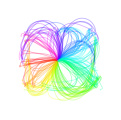

In [5]:
from ldns.data.monkey import LatentMonkeyDataset

latent_dataset_train = LatentMonkeyDataset(train_dataloader, ae_model, clip=False)
latent_dataset_val = LatentMonkeyDataset(
    val_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)
latent_dataset_test = LatentMonkeyDataset(
    test_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)

train_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_train,
    batch_size=cfg.training.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_val,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_test,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

num_batches = len(train_latent_dataloader)

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x

# prepare the denoiser model and dataset
(
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
) = accelerator.prepare(
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
)

# create cmap based on behavior angles and plot behavior_cumsum on 2d plot
cmap = plt.get_cmap("hsv")
colors = cmap((latent_dataset_train.behavior_angles.squeeze() + np.pi) / (2 * np.pi))

plt.figure(figsize=cm2inch(2, 2))

for i in range(0, len(latent_dataset_train.behavior), 10):
    plt.plot(
        latent_dataset_train.behavior_cumsum[i, 0],
        latent_dataset_train.behavior_cumsum[i, 1],
        color=colors[i],
        alpha=0.3,
        lw=0.4,
    )

# switch off axis
plt.axis("off")

# Load the unconditional diffusion model 

In [ ]:
from ldns.utils.sampling_utils import sample, sample_spikes

denoiser = Denoiser(
    C_in=cfg.denoiser_model.C_in,
    C=cfg.denoiser_model.C,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.denoiser_model.num_blocks,
    bidirectional=cfg.denoiser_model.get("bidirectional", True),
)

scheduler = DDPMScheduler(
    num_train_timesteps=cfg.denoiser_model.num_train_timesteps,
    clip_sample=False,
    beta_schedule="linear",
)


denoiser.load_state_dict(torch.load(f"exp/stored_models/{cfg.exp_name}/model.pt", map_location="cpu"))

# prepare the denoiser model and dataset
denoiser = accelerator.prepare(denoiser)

ema_model = EMAModel(denoiser)  # for eval and no grad

print(f"loaded model from exp/stored_models/{cfg.exp_name}/model.pt")

# Create tensors for comparison

In [8]:
from ldns.utils.sampling_utils import sample
from ldns.utils.utils import set_seed
import pickle

fps_monkey = 1000 / 5

load_from_disc = False  # setting to false will take 4-5 min to run

save_data_path = "exp/stored_spike_samples/"

if load_from_disc and os.path.exists(save_data_path + "unconditional_diffusion_data_dict.pkl"):
    with open(save_data_path + "unconditional_diffusion_data_dict.pkl", "rb") as f:
        unconditional_diffusion_data_dict = pickle.load(f)

    ae_rates = unconditional_diffusion_data_dict["ae_rates"]
    ae_latents = unconditional_diffusion_data_dict["ae_latents"]
    diffusion_rates = unconditional_diffusion_data_dict["diffusion_rates"]
    diffusion_latents = unconditional_diffusion_data_dict["diffusion_latents"]
    gt_spikes = unconditional_diffusion_data_dict["gt_spikes"]

else:  # takes 4-5 min
    # ensure reproducibility
    set_seed(42)

    true_data = True
    sample_cutoff = int(10e5)
    ae_model.eval()

    ae_rates = []
    ae_latents = []
    diffusion_rates = []
    diffusion_latents = []
    gt_spikes = []

    if not true_data:
        gt_rates = []
        gt_latents = []

    # autoencoder eval
    for batch in train_dataloader:
        signal = batch["signal"]
        with torch.no_grad():
            output_rates, latent = ae_model(signal)
            # output_rates = ae_model(signal)[0].cpu()
        ae_rates.append(output_rates.cpu())
        ae_latents.append(latent.cpu())
        gt_spikes.append(signal.cpu())
        if not true_data:
            gt_rates.append(batch["rates"].cpu())
            gt_latents.append(batch["latents"].cpu())

        # break

    # concatenate along batch dimension
    ae_rates = torch.cat(ae_rates, dim=0)
    ae_latents = torch.cat(ae_latents, dim=0)
    gt_spikes = torch.cat(gt_spikes, dim=0)
    if not true_data:
        gt_rates = torch.cat(gt_rates, dim=0)
        gt_latents = torch.cat(gt_latents, dim=0)

    # diffusion eval
    sampled_latents = sample(
        ema_denoiser=ema_model,
        scheduler=scheduler,
        cfg=cfg,
        batch_size=ae_rates.shape[0],
        device="cuda",
        signal_length=cfg.dataset.signal_length,
    )

    # project back to non standardized space
    sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
        sampled_latents.device
    ) + latent_dataset_train.latent_means.to(sampled_latents.device)

    with torch.no_grad():
        sampled_rates = ae_model.decode(sampled_latents).cpu()

    diffusion_rates.append(sampled_rates)
    diffusion_latents.append(sampled_latents.cpu())

    # concatenate along batch dimension
    diffusion_rates = torch.cat(diffusion_rates, dim=0)
    diffusion_latents = torch.cat(diffusion_latents, dim=0)

    vecs = [ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes]

    if not true_data:
        vecs.append(gt_rates)
        vecs.append(gt_latents)

    vecs = [vec.cpu().numpy() for vec in vecs]
    vecs = [vec[:sample_cutoff] for vec in vecs]
    vecs = [rearrange(vec, "b n t -> b t n") for vec in vecs]

    if not true_data:
        ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes, gt_rates, gt_latents = vecs
    else:
        ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes = vecs

    unconditional_diffusion_data_dict = {
        "ae_rates": ae_rates,
        "ae_latents": ae_latents,
        "diffusion_rates": diffusion_rates,
        "diffusion_latents": diffusion_latents,
        "gt_spikes": gt_spikes,
    }
    # save this dict to disk
    import pickle

    with open(save_data_path + "unconditional_diffusion_data_dict.pkl", "wb") as f:
        pickle.dump(unconditional_diffusion_data_dict, f)


Sampling DDPM: 100%|██████████| 1000/1000 [05:38<00:00,  2.96it/s]


### Figure 4 b

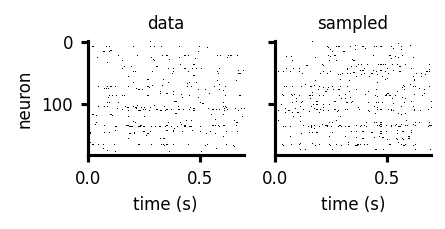

In [12]:
fig, ax = plt.subplots(1, 2, figsize=cm2inch(7.5, 2.5), sharey=True)

# ----------- Binarize the data ------------

data_binary_spikes = gt_spikes[0].T > 0
sampled_binary_spikes = np.random.poisson(diffusion_rates[0].T) > 0

# Display data
im = ax[0].imshow(data_binary_spikes, aspect="auto", cmap="Greys", vmax=1)
ax[0].set_title("data")

# Set the x-ticks to display time in seconds for data
time_points = data_binary_spikes.shape[1]
fps = fps_monkey
time_interval = 1 / fps
second_ticks = fps / 2  # ticks every 0.25 seconds
xticks = np.arange(0, time_points, second_ticks)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([f"{x * time_interval:.1f}" for x in xticks])

# Display sampled spikes
im = ax[1].imshow(sampled_binary_spikes, aspect="auto", cmap="Greys", vmax=1)
ax[1].set_title("sampled")

# Set the x-ticks to display time in seconds for sampled data
ax[1].set_xticks(xticks)
ax[1].set_xticklabels([f"{x * time_interval:.1f}" for x in xticks])
ax[0].set_xlabel("time (s)")
ax[1].set_xlabel("time (s)")
ax[0].set_ylabel("neuron")

plt.show()

### Supp Fig. A11: 5 additional data samples

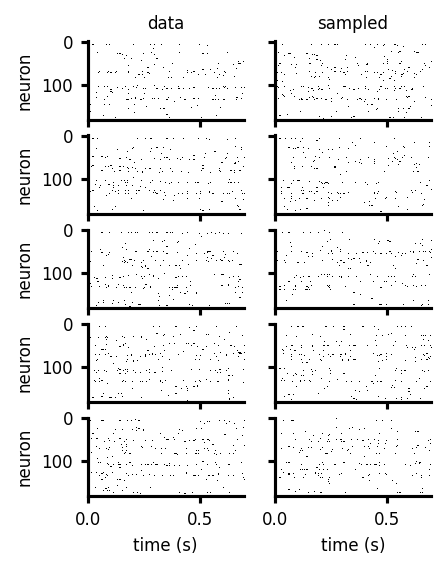

In [13]:
fig, ax = plt.subplots(5, 2, figsize=cm2inch(7.5, 10), sharey=True, sharex=True)

# ----------- Binarize the data ------------
for dd in range(5):
    data_binary_spikes = gt_spikes[dd].T > 0
    sampled_binary_spikes = np.random.poisson(diffusion_rates[dd].T) > 0

    # Display data
    im = ax[dd, 0].imshow(data_binary_spikes, aspect="auto", cmap="Greys", vmax=1)
    # fig.colorbar(im, ax=ax[0], orientation="vertical", fraction=0.046, pad=0.04)

    # Set the x-ticks to display time in seconds for data
    time_points = data_binary_spikes.shape[1]
    fps = fps_monkey
    time_interval = 1 / fps
    second_ticks = fps / 2  # ticks every 0.25 seconds
    xticks = np.arange(0, time_points, second_ticks)
    ax[dd, 0].set_xticks(xticks)
    ax[dd, 0].set_xticklabels([f"{x * time_interval:.1f}" for x in xticks])

    # Display sampled spikes
    im = ax[dd, 1].imshow(sampled_binary_spikes, aspect="auto", cmap="Greys", vmax=1)
    # fig.colorbar(im, ax=ax[1], orientation="vertical", fraction=0.046, pad=0.04)

    # Set the x-ticks to display time in seconds for sampled data
    ax[dd, 1].set_xticks(xticks)
    ax[dd, 1].set_xticklabels([f"{x * time_interval:.1f}" for x in xticks])
    ax[dd, 0].set_xlabel("time (s)")
    ax[dd, 1].set_xlabel("time (s)")
    ax[dd, 0].set_ylabel("neuron")
ax[0, 0].set_title("data")
ax[0, 1].set_title("sampled")

plt.show()

# Read spikes from baselines LFADS, TNDM and pi-VAE as well as spike history variants of LFADS and LDNS

In [14]:
# read in baseline data for comparison
baseline_path = "exp/stored_spike_samples/"
# lfads, tndm and pi-vae samples sampled from the prior and passed through the decoder

with open(baseline_path + "lfads_samples.pkl", "rb") as f:
    lfads_samples = pickle.load(f)
lfads_spikes = lfads_samples["model_spikes"]
lfads_rates = lfads_samples["model_rates"]


with open(baseline_path + "history_sampled_dict.pkl", "rb") as f:
    history_sampled_dict = pickle.load(f)
hist_spikes = history_sampled_dict["hist"][1]
hist_spikes_list = history_sampled_dict["hist"]


with open(baseline_path + "tndm.pkl", "rb") as f:
    tndm_samples = pickle.load(f)
set_seed(42)
tndm_spikes = np.random.poisson(tndm_samples["diffusion_rates"])  # note not diffusion but vae prior samples

with open(baseline_path + "samples_pivae_1.pkl", "rb") as f:
    pivae_samples = pickle.load(f)
set_seed(42)
pivae_spikes = np.random.poisson(pivae_samples["diffusion_rates"])  # note not diffusion but vae prior samples


# lfads with spike history
with open(baseline_path + "history_sampled_dict_lfads_5.pkl", "rb") as f:
    history_sampled_dict_lfads = pickle.load(f)

hist_spikes_lfads = history_sampled_dict_lfads["hist"][0]
hist_spikes_list_lfads = history_sampled_dict_lfads["hist"]

load_from_disc = True

if load_from_disc:
    with open(save_data_path + "unconditional_diffusion_data_dict.pkl", "rb") as f:
        unconditional_diffusion_data_dict = pickle.load(f)

    ae_rates = unconditional_diffusion_data_dict["ae_rates"]
    ae_latents = unconditional_diffusion_data_dict["ae_latents"]
    diffusion_rates = unconditional_diffusion_data_dict["diffusion_rates"]
    diffusion_latents = unconditional_diffusion_data_dict["diffusion_latents"]
    gt_spikes = unconditional_diffusion_data_dict["gt_spikes"]


# -----------  decide what to visualise ------------

methods = ["pivae", "tndm", "lfads", "lfadshist", "ldns", "hist", "train"]
comparison_stats = [
    "kl_div_psc",
    "rmse_corr",
    "rmse_mean_isi",
    "rmse_std_isi",
]
selected_methods = ["pivae", "tndm", "lfads", "lfadshist", "ldns", "hist", "train"]


color_dict = {
    "pivae": "#DACD95",
    "tndm": "#7796A6",
    "lfads": "#9f86c0",  # 632075',#'#50547C',
    "ldns": "#A44A3F",
    "lfadshist": "#BA8CB2",  #'magenta',
    "hist": "#495F41",
    "train": "grey",
}


In [15]:
set_seed(42)
spikes_dict_single = {
    "tndm": tndm_spikes,
    "pivae": pivae_spikes,
    "lfads": lfads_spikes,
    "lfadshist": hist_spikes_lfads,
    "ldns": np.random.poisson(diffusion_rates),
    "hist": hist_spikes,
    "train": gt_spikes,
}

list_indices = [np.random.choice(len(gt_spikes), len(gt_spikes), replace=True) for _ in range(5)]

print(len(gt_spikes), len(list_indices))


def get_folds(spikes, indices):
    """Return spikes sampled according to the provided indices."""
    return spikes[indices]


# Create the spikes dictionary for each model across 5 folds
spikes_dict = {
    "lfads": [get_folds(spikes_dict_single["lfads"], idx) for idx in list_indices],
}

for key in spikes_dict_single.keys():
    if key not in spikes_dict:
        spikes_dict[key] = [get_folds(spikes_dict_single[key], idx) for idx in list_indices]

2008 5


### Supp. Fig. A14 spike samples from all methods

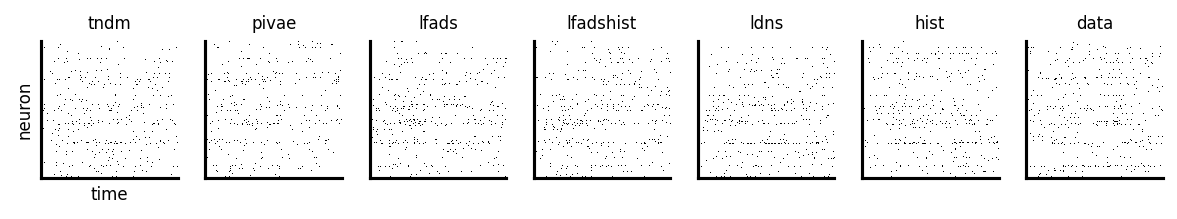

In [16]:
# plot the first trial spikes for all models
n_comparisons = len(spikes_dict_single.keys())
fig, ax = plt.subplots(1, n_comparisons, figsize=cm2inch(n_comparisons * 3.5, 3), sharey=True)
for i, (key, spikes) in enumerate(spikes_dict_single.items()):
    ax[i].imshow(spikes[list_indices[0]][0].T > 0, aspect="auto", cmap="Greys", vmax=1)
    ax[i].set_title(key if key != "train" else "data")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[0].set_ylabel("neuron")
ax[0].set_xlabel("time")

plt.show()

# Save the spikes for LFADS embedding 

In [17]:
spikes_to_analyse_PCA = {
    "tndm": tndm_spikes,
    "pivae": pivae_spikes,
    "lfads_spikes": lfads_spikes,
    "hist_spikes": hist_spikes,
    "lfadshist_spikes": hist_spikes_lfads,
    "ldns_spikes": np.random.poisson(diffusion_rates),
    "gt_spikes": gt_spikes,
}

import pickle

with open(save_data_path + f"spikes_to_analyse_PCA_{len(spikes_to_analyse_PCA.keys())}.pkl", "wb") as f:
    pickle.dump(spikes_to_analyse_PCA, f)

# make main comparison loop here

In [18]:
# import evaluation utilities
from ldns.utils.eval_utils import (
    rmse_nan,
    average_rates,
    std_rates,
    kl_div,
    correlation_matrix,
)
from ldns.utils.eval_utils import (
    compute_spike_stats_per_neuron,
    counts_to_spike_trains,
)
from scipy.stats import gaussian_kde
from ldns.utils.eval_utils import group_neurons_temp_corr, get_temp_corr_summary

# Initialize the comparison statistics dictionary
comp_dict = {method: {stat: [] for stat in comparison_stats} for method in methods}


def rmse_mean_rate(spikes, gt):
    """Calculate RMSE between mean firing rates of spikes and ground truth.

    Args:
        spikes: Generated spike counts array
        gt: Ground truth spike counts array

    Returns:
        RMSE between mean firing rates
    """
    gt_m = average_rates(
        gt,
        mode="neur",
        fps=fps_monkey,
    ).flatten()
    spikes_m = average_rates(spikes, mode="neur", fps=fps_monkey).flatten()
    return rmse_nan(gt_m, spikes_m)


def rmse_std_rate(spikes, gt):
    """Calculate RMSE between standard deviations of firing rates.

    Args:
        spikes: Generated spike counts array
        gt: Ground truth spike counts array

    Returns:
        RMSE between firing rate standard deviations
    """
    gt_s = std_rates(
        gt,
        mode="neur",
        fps=fps_monkey,
    ).flatten()
    spikes_s = std_rates(spikes, mode="neur", fps=fps_monkey).flatten()
    return rmse_nan(gt_s, spikes_s)


def get_spike_train_and_stats(spikes, fps=200):
    """Convert spike counts to spike trains and compute statistics.

    Args:
        spikes: Spike counts array
        fps: Sampling rate in Hz

    Returns:
        Dictionary of spike train statistics
    """
    spiketrain = counts_to_spike_trains(spikes, fps=fps)
    spike_stats_m = compute_spike_stats_per_neuron(
        spiketrain,
        n_samples=spikes.shape[0],
        n_neurons=spikes.shape[2],
        mean_output=False,
    )
    return spike_stats_m


def calculate_statistics(
    spikes,
    gt,
    spike_stats_gt=None,
    maxval=17,
    calc_isi=True,
    temp_corr=False,
    groups_dict=None,
):
    """Calculate comparison statistics between generated and ground truth spikes.

    Args:
        spikes: Generated spike counts
        gt: Ground truth spike counts
        spike_stats_gt: Pre-computed ground truth statistics (optional)
        maxval: Maximum spike count for histogram
        calc_isi: Whether to calculate ISI statistics
        temp_corr: Whether to calculate temporal correlations
        groups_dict: Neuron grouping information for temporal correlations

    Returns:
        Dictionary of comparison statistics
    """
    # calculate spike stats for model spikes and gt spikes
    if spike_stats_gt is None:
        spike_stats_gt = get_spike_train_and_stats(gt, fps=fps_monkey)

    if calc_isi:
        spike_stats_model = get_spike_train_and_stats(spikes, fps=fps_monkey)
    else:
        spike_stats_model = spike_stats_gt
        print("CAUTION NOT CALCULATING SPIKE STATS")

    # population spike count histogram using gaussian kde
    kde_model = gaussian_kde(spikes.sum(2).flatten())
    kde_gt = gaussian_kde(gt.sum(2).flatten())
    x_eval = np.linspace(0, maxval, maxval + 1)
    density_model = kde_model(x_eval)
    density_gt = kde_gt(x_eval)
    density_model /= density_model.sum()
    density_gt /= density_gt.sum()

    # calculate correlation matrices
    C_model = correlation_matrix(spikes, mode="concatenate")
    np.fill_diagonal(C_model, 0)
    C_model = np.tril(C_model, k=-1)

    C_gt = correlation_matrix(gt, mode="concatenate")
    np.fill_diagonal(C_gt, 0)
    C_gt = np.tril(C_gt, k=-1)

    # temporal correlations if requested
    if temp_corr:
        cross_corr_groups_model, auto_corr_groups_model = get_temp_corr_summary(
            spikes.transpose(1, 0, 2),
            groups_dict["groups"],
            nlags=30,
            mode="biased",
            batch_first=False,
        )
        number_of_groups = 2  # limit to lower two groups with low correlation

    return {
        "kl_div_psc": kl_div(density_model, density_gt),
        "rmse_corr": rmse_nan(C_model, C_gt),
        "rmse_mean_isi": rmse_nan(spike_stats_model["mean_isi"], spike_stats_gt["mean_isi"]),
        "rmse_std_isi": rmse_nan(spike_stats_model["std_isi"], spike_stats_gt["std_isi"]),
    }


def compute_stats(comp_dict):
    """Compute mean and standard deviation of comparison statistics.

    Args:
        comp_dict: Dictionary of comparison statistics

    Returns:
        Dictionary of means and standard deviations
    """
    stats_results = {method: {} for method in comp_dict}
    for method, metrics in comp_dict.items():
        for metric, values in metrics.items():
            mean_val = np.mean(values)
            std_val = np.std(values)
            stats_results[method][metric] = (mean_val, std_val)
    return stats_results


def plot_metrics(comp_dict, ncols=3, figsize=cm2inch(15, 10)):
    """Plot comparison metrics for all methods.

    Args:
        comp_dict: Dictionary of comparison statistics
        ncols: Number of columns in plot grid
        figsize: Figure size in inches

    Returns:
        matplotlib figure
    """
    stats_results = compute_stats(comp_dict)
    metrics = next(iter(comp_dict.values())).keys()
    num_metrics = len(metrics)
    fig, axes = plt.subplots(
        nrows=int(num_metrics / ncols),
        ncols=ncols,
        figsize=figsize,
        constrained_layout=True,
    )
    axes = axes.flatten()

    for ax, metric in zip(axes, metrics):
        methods = list(stats_results.keys())
        means = [stats_results[method][metric][0] for method in methods]
        stds = [stats_results[method][metric][1] for method in methods]
        method_colors = [color_dict[method] for method in methods]

        ax.bar(methods, means, yerr=stds, capsize=5, alpha=0.7, color=method_colors)
        ax.set_title(metric.replace("_", " "))
        ax.set_ylabel("value")

    # hide unused axes
    if len(axes) > num_metrics:
        axes[-1].axis("off")
    return fig


def plot_metrics_selected(
    comp_dict,
    selected_methods=None,
    selected_comparison_stats=None,
    ncols=3,
    figsize=cm2inch(17, 10),
):
    """Plot comparison metrics for selected methods and statistics.

    Args:
        comp_dict: Dictionary of comparison statistics
        selected_methods: List of methods to plot
        selected_comparison_stats: List of statistics to plot
        ncols: Number of columns in plot grid
        figsize: Figure size in inches

    Returns:
        matplotlib figure
    """
    stats_results = compute_stats(comp_dict)
    if selected_comparison_stats is None:
        metrics = next(iter(comp_dict.values())).keys()
    else:
        metrics = selected_comparison_stats
    num_metrics = len(metrics)
    fig, axes = plt.subplots(
        nrows=int(num_metrics / ncols),
        ncols=ncols,
        figsize=figsize,
        constrained_layout=True,
    )
    axes = axes.flatten()

    for ax, metric in zip(axes, metrics):
        methods = list(stats_results.keys())
        means = [stats_results[method][metric][0] for method in methods]
        stds = [stats_results[method][metric][1] for method in methods]
        method_colors = [color_dict[method] for method in methods]

        ax.bar(methods, means, yerr=stds, capsize=5, alpha=0.7, color=method_colors)
        ax.set_title(metric.replace("_", " "))
        ax.set_ylabel("value")

    # hide unused axes
    if len(axes) > num_metrics:
        axes[-1].axis("off")
    return fig

# Run the comparison evaluation loop (~10 minutes)

In [19]:
load_from_disc = False  # else will take 10 min to run

if not load_from_disc or not os.path.exists(
    save_data_path + f"comp_dict_5_folds_relevant_metrics_with_more_baselines.pkl"
):
    comp_dict = {method: {stat: [] for stat in comparison_stats} for method in methods}
    # this calculation takes time so worth calculating beforehand
    fps_monkey = 1000 / 5
    spike_stats_gt = get_spike_train_and_stats(gt_spikes, fps=fps_monkey)
    temp_corr = False

    if temp_corr:  # should temporal correlations be included
        # load again
        if os.path.exists(save_data_path + "cross_corr_gt.pkl"):
            with open(save_data_path + "cross_corr_gt.pkl", "rb") as f:
                groups_dict = pickle.load(f)
        else:
            groups = group_neurons_temp_corr(gt_spikes.transpose(1, 0, 2), num_groups=4)
            cross_corr_groups, auto_corr_groups = get_temp_corr_summary(
                gt_spikes.transpose(1, 0, 2),
                groups,
                nlags=30,
                mode="biased",
                batch_first=False,
            )
            groups_dict = {
                "cross_corr_groups": cross_corr_groups,
                "auto_corr_groups": auto_corr_groups,
                "groups": groups,
            }
            with open(save_data_path + "cross_corr_gt.pkl", "wb") as f:
                pickle.dump(groups_dict, f)
    else:
        groups_dict = None

    # get the overall maximum population spike count to calculate the kl div
    max_vals = []
    for key in spikes_dict_single.keys():
        max_vals.append(spikes_dict_single[key].sum(2).max())
    maxval = int(np.max(max_vals))

    # Loop over methods and folds to compute and store the statistics
    from tqdm import tqdm

    for method in tqdm(methods, desc="Computing stats for methods"):
        for fold in tqdm(range(5), desc=f"Processing folds for {method}", leave=False):
            model_spikes = spikes_dict[method][fold]
            gt_data = gt_spikes  # Assuming gt_spikes is the ground truth for all
            if method == "train":
                # make a random split of the data
                indices = np.random.choice(len(gt_data), int(len(gt_data) / 2), replace=False)
                # other indices
                other_indices = np.setdiff1d(np.arange(len(gt_data)), indices)
                gt_data = gt_data[indices]
                model_spikes = model_spikes[other_indices]
            stats = calculate_statistics(
                model_spikes,
                gt_data,
                spike_stats_gt=spike_stats_gt,
                maxval=maxval,
                groups_dict=groups_dict,
                temp_corr=temp_corr,
            )

            for stat in comparison_stats:
                comp_dict[method][stat].append(stats[stat])

    # save picke files in save_data_path
    with open(
        save_data_path + "comp_dict_5_folds_relevant_metrics_with_more_baselines.pkl",
        "wb",
    ) as f:
        pickle.dump(comp_dict, f)


else:
    with open(
        save_data_path + f"comp_dict_5_folds_relevant_metrics_with_more_baselines.pkl",
        "rb",
    ) as f:
        comp_dict = pickle.load(f)

Computing stats for methods: 100%|██████████| 7/7 [14:10<00:00, 121.48s/it]


#### Sup Fig. A13

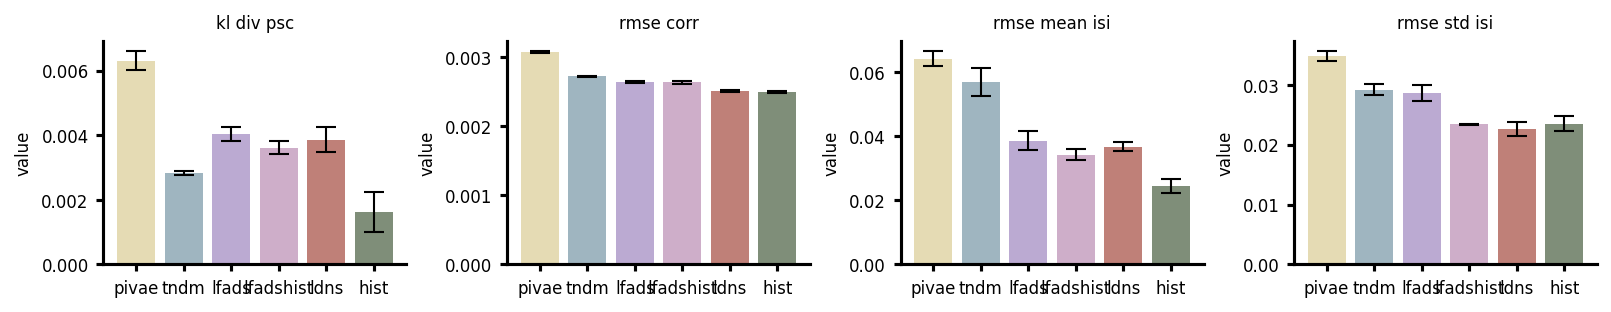

In [20]:
comp_dict_no_train = {key: value for key, value in comp_dict.items() if key != "train"}
selected_comparison_stats = [
    "kl_div_psc",
    "rmse_corr",
    "rmse_mean_isi",
    "rmse_std_isi",
]

fig = plot_metrics_selected(
    comp_dict_no_train, selected_comparison_stats=selected_comparison_stats, figsize=cm2inch(27, 5), ncols=4
)

plt.show()

In [16]:
# sort keys differently

comp_dict_ordered = {
    "pivae": comp_dict["pivae"],
    "tndm": comp_dict["tndm"],
    "lfads": comp_dict["lfads"],
    "ldns": comp_dict["ldns"],
    "lfadshist": comp_dict["lfadshist"],
    "hist": comp_dict["hist"],
    "train": comp_dict["train"],
}


### Table 1: comparison LDNS AutoLFADS and spike history variants

In [ ]:
# print the computed statistics mean and std
stats_results = compute_stats(comp_dict_ordered)
stats_results

{'pivae': {'kl_div_psc': (0.006298258439274183, 0.00029413859024938246),
  'rmse_corr': (0.0030770709230841984, 1.0782468250055586e-05),
  'rmse_mean_isi': (0.06414194303954941, 0.0022411323597526004),
  'rmse_std_isi': (0.03475195374577855, 0.0008255917209868428)},
 'tndm': {'kl_div_psc': (0.0028244468145621074, 6.359919248384585e-05),
  'rmse_corr': (0.0027242135792086156, 1.1696648190019326e-05),
  'rmse_mean_isi': (0.05686715442433628, 0.0044540885527635625),
  'rmse_std_isi': (0.02919417097420642, 0.0008833104328119203)},
 'lfads': {'kl_div_psc': (0.004047887887556495, 0.00021866181223549277),
  'rmse_corr': (0.0026394195197127603, 1.2459980856280937e-05),
  'rmse_mean_isi': (0.038572645893827785, 0.002960756633331008),
  'rmse_std_isi': (0.02857548225379817, 0.0013314130254322859)},
 'ldns': {'kl_div_psc': (0.0037875010929502946, 0.0004416293412569771),
  'rmse_corr': (0.002513568010753258, 1.0976574311849013e-05),
  'rmse_mean_isi': (0.036715109194014536, 0.0013350362887112736),

### Figure 4 c,d and Supp. Fig 16

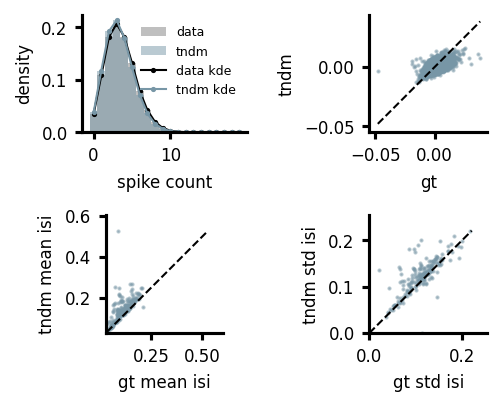

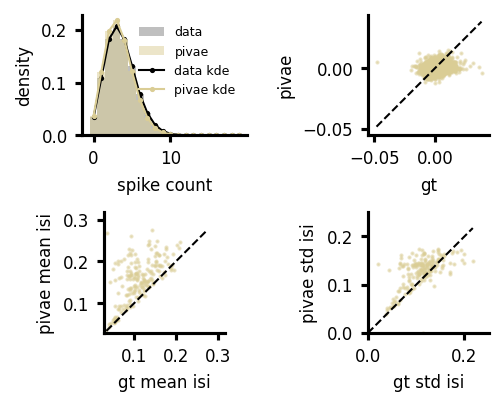

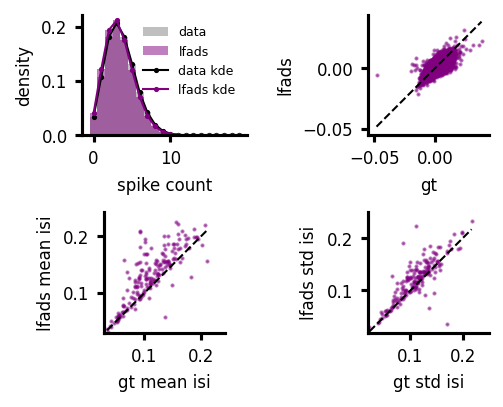

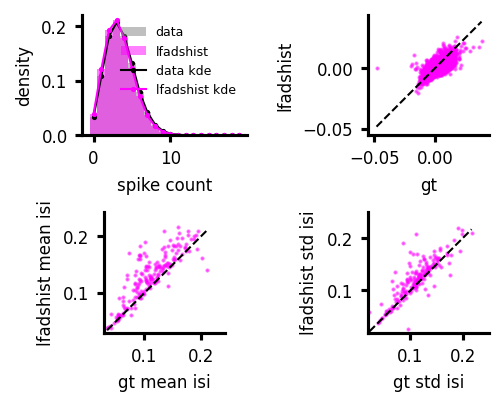

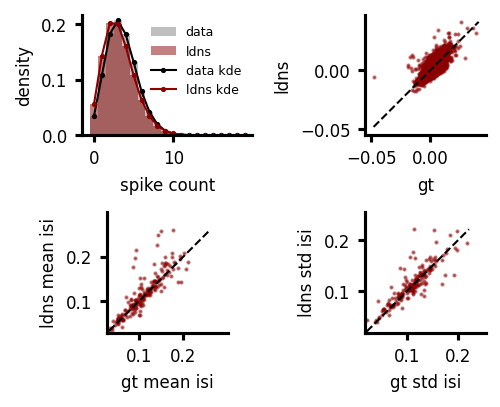

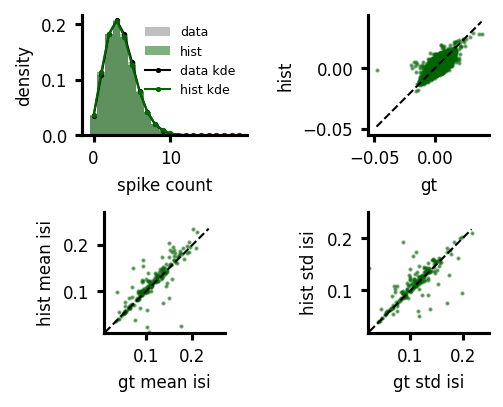

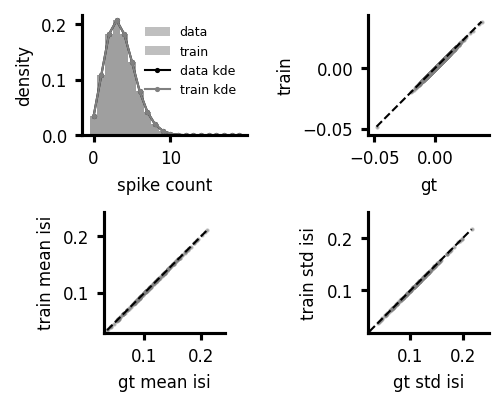

In [21]:
# plot population spike histogram for diffusion as well as correlation and isi

color_dict_plots = {
    "pivae": "#DACD95",
    "tndm": "#7796A6",
    "lfads": "purple",
    "ldns": "darkred",
    "hist": "darkgreen",
    "lfadshist": "magenta",
    "train": "grey",
}

max_vals = []
for key in spikes_dict_single.keys():
    max_vals.append(spikes_dict_single[key].sum(2).max())
maxval = int(np.max(max_vals))


for i, (key, val) in enumerate(spikes_dict_single.items()):
    # if key != 'ldns':
    #     continue
    fig, ax = plt.subplots(2, 2, figsize=cm2inch(9, 7))
    ax = ax.flatten()
    kde_model = gaussian_kde(val.sum(2).flatten())
    kde_gt = gaussian_kde(gt_spikes.sum(2).flatten())

    # Evaluating densities over a common range derived from data
    x_eval = np.linspace(0, maxval, maxval + 1)
    density_model = kde_model(x_eval)
    density_gt = kde_gt(x_eval)
    density_model /= density_model.sum()
    density_gt /= density_gt.sum()

    bins_psc = np.arange(-0.5, maxval - 0.5, 1)
    # plot the population spike count histogram for the lfads model and the data
    ax[0].hist(gt_spikes.sum(2).flatten(), bins=bins_psc, density=True, alpha=0.5, label="data", color="grey")
    ax[0].hist(val.sum(2).flatten(), bins=bins_psc, density=True, alpha=0.5, label=key, color=color_dict_plots[key])

    # now plot the density estimate
    ax[0].plot(x_eval, density_gt, ".-", label="data kde", color="black")
    ax[0].plot(x_eval, density_model, ".-", label=key + " kde", color=color_dict_plots[key])

    ax[0].legend(fontsize=6)
    ax[0].set_xlabel("spike count")
    ax[0].set_ylabel("density")

    # now plot the correlation matrix

    # get the correlation structure
    C_model = correlation_matrix(val, mode="concatenate")
    np.fill_diagonal(C_model, 0)
    C_model = np.tril(C_model, k=-1)

    C_gt = correlation_matrix(gt_spikes, mode="concatenate")
    np.fill_diagonal(C_gt, 0)
    C_gt = np.tril(C_gt, k=-1)

    ax[1].plot(C_gt.flatten(), C_model.flatten(), ".", alpha=0.5, color=color_dict_plots[key], ms=2)
    data_limits = [min(C_gt.min(), C_model.min()), max(C_gt.max(), C_model.max())]
    ax[1].plot([data_limits[0], data_limits[1]], [data_limits[0], data_limits[1]], "--", color="black")
    ax[1].set_xlabel("gt")
    ax[1].set_ylabel(key)
    ax[1].set_aspect("equal")
    data_limis_ax = [data_limits[0] - 0.15 * np.abs(data_limits[0]), data_limits[1] + 0.15 * np.abs(data_limits[1])]
    ax[1].set_xlim(data_limis_ax)
    ax[1].set_ylim(data_limis_ax)

    # compute the spikes stats
    spike_stats_gt = get_spike_train_and_stats(gt_spikes, fps=fps_monkey)

    spike_stats_model = get_spike_train_and_stats(val, fps=fps_monkey)

    ax[2].plot(
        spike_stats_gt["mean_isi"].flatten(),
        spike_stats_model["mean_isi"].flatten(),
        ".",
        alpha=0.5,
        color=color_dict_plots[key],
        ms=2,
    )
    data_limits = [
        min(spike_stats_gt["mean_isi"].flatten().min(), spike_stats_model["mean_isi"].flatten().min()),
        max(spike_stats_gt["mean_isi"].flatten().max(), spike_stats_model["mean_isi"].flatten().max()),
    ]
    ax[2].plot([data_limits[0], data_limits[1]], [data_limits[0], data_limits[1]], "--", color="black")
    ax[2].set_xlabel("gt mean isi")
    ax[2].set_ylabel(key + " mean isi")
    ax[2].set_aspect("equal")
    data_limis_ax = [data_limits[0] - 0.15 * np.abs(data_limits[0]), data_limits[1] + 0.15 * np.abs(data_limits[1])]
    ax[2].set_xlim(data_limis_ax)
    ax[2].set_ylim(data_limis_ax)

    ax[3].plot(
        spike_stats_gt["std_isi"].flatten(),
        spike_stats_model["std_isi"].flatten(),
        ".",
        alpha=0.5,
        color=color_dict_plots[key],
        ms=2,
    )
    data_limits = [
        min(spike_stats_gt["std_isi"].flatten().min(), spike_stats_model["std_isi"].flatten().min()),
        max(spike_stats_gt["std_isi"].flatten().max(), spike_stats_model["std_isi"].flatten().max()),
    ]
    ax[3].plot([data_limits[0], data_limits[1]], [data_limits[0], data_limits[1]], "--", color="black")
    ax[3].set_xlabel("gt std isi")
    ax[3].set_ylabel(key + " std isi")
    ax[3].set_aspect("equal")
    data_limis_ax = [data_limits[0] - 0.15 * np.abs(data_limits[0]), data_limits[1] + 0.15 * np.abs(data_limits[1])]
    ax[3].set_xlim(data_limis_ax)
    ax[3].set_ylim(data_limis_ax)

    plt.tight_layout()

    plt.show()

### Supp. Fig. A10 Correlation Matrices

[0.048030580379949, 0.03280902557068793]
[0.048030580379949, 0.03280902557068793, 0.036548910924286485]


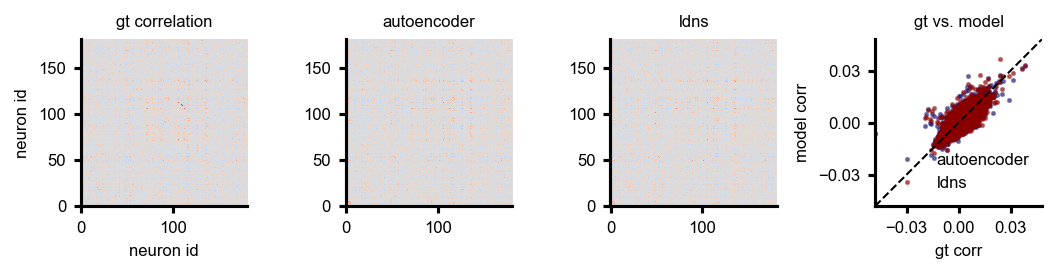

In [19]:
from ntldm.utils.eval_utils import correlation_matrix
from ntldm.utils.plotting_utils import plot_correlation_matrices_monkey

# Compute correlation matrices for one sample sequence
set_seed(42)
ae_spikes = np.random.poisson(ae_rates)
diffusion_spikes = np.random.poisson(diffusion_rates)


plot_correlation_matrices_monkey(
    gt_spikes,
    [ae_spikes, diffusion_spikes],
    sample=None,
    mode="concatenate",
    model_labels=["autoencoder", "ldns"],
    model_colors=["midnightblue", "darkred"],
    figsize=cm2inch((18, 6)),
    save=True,
    save_path=save_path + "Supp_Fig_correlation_matrices_ae_diffusion_monkey",
    ticks=[-0.03, 0, 0.03],
)

# Diffusion power spectral density checks 

Caution: Ensure fps is correct here.... PSD fps: 200.0


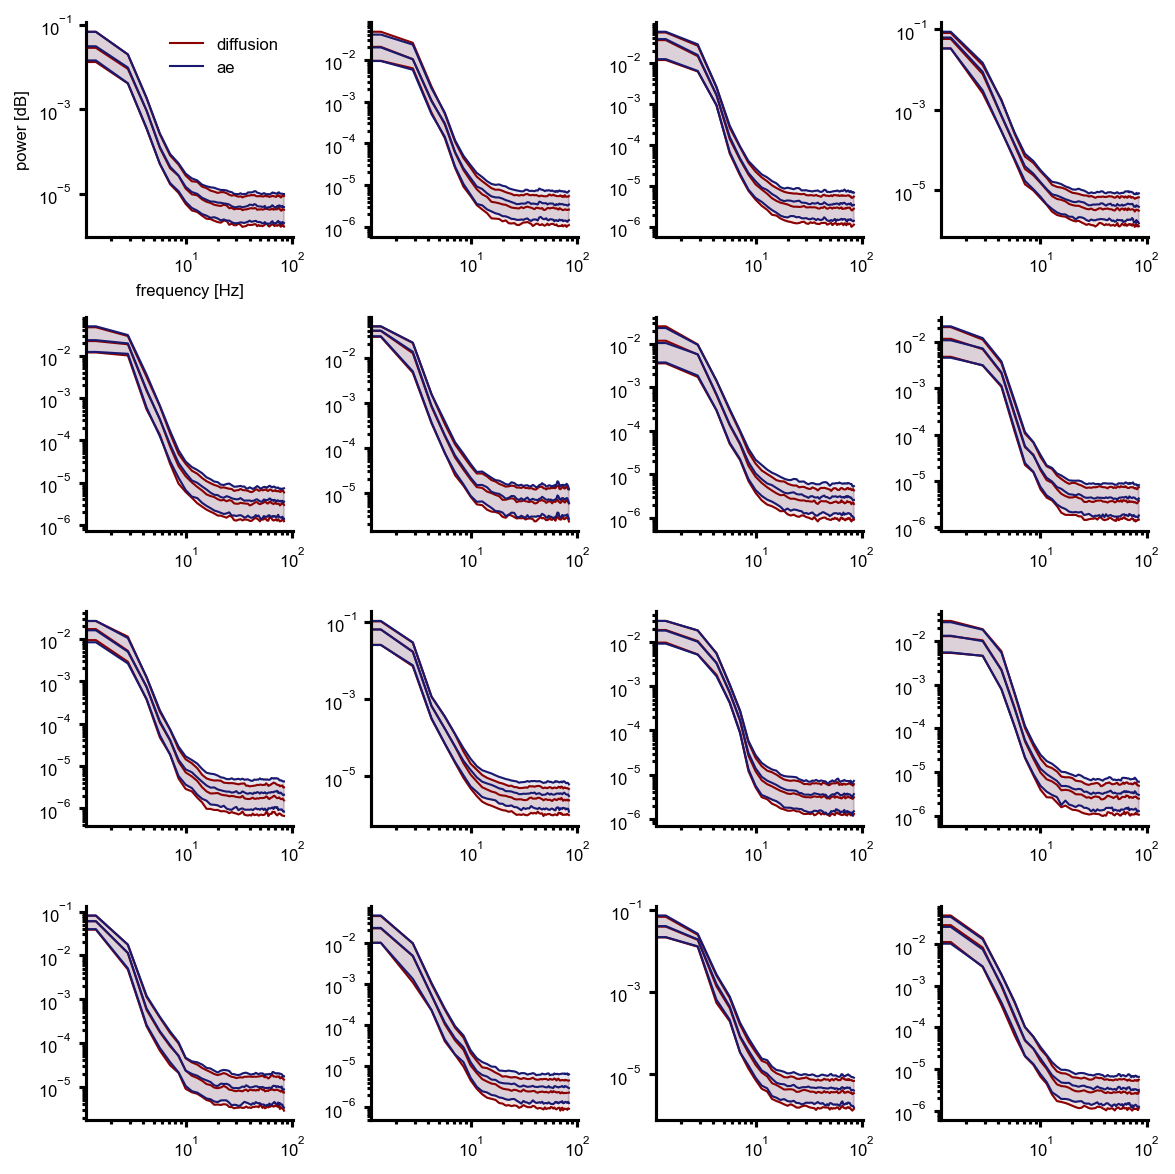

In [22]:
fps = 1000 / 5
plot_n_channel_sd(
    diffusion_latents,
    ae_latents,
    channels=np.arange(16),
    fps=fps,
    save=False,
    save_path=None,
    colors=["darkred", "midnightblue"],
    labels=["diffusion", "ae"],
    ystack=4,
    figsize=cm2inch(20, 20),
)

# PCA on the true and generated spikes to evaluate temporal features 


In [23]:
import pickle

# now load the data
with open(save_data_path + f"train_spikes_to_analyse_with_LFADS_more_baselines_7.pkl", "rb") as f:
    spikes_to_analyse_with_LFADS = pickle.load(f)
spikes_to_analyse_with_LFADS.keys()

dict_keys(['tndm', 'pivae', 'lfads_spikes', 'hist_spikes', 'lfadshist_spikes', 'ldns_spikes', 'gt_spikes'])

In [24]:
# include spectral density plotting functions
def plot_sd_return_vals(
    fig,
    ax,
    arr_one,
    arr_two,
    fs,
    nperseg,
    agg_function=np.median,
    color_one="red",
    color_two="blue",
    label_one="gt",
    label_two="rec",
    with_quantiles=False,
    alpha=0.1,
    lower_quantile=0.25,
    upper_quantile=0.75,
    alpha_boundary=1.0,
    x_ss=slice(None),
    add_legend=False,
    lw=1,
):
    """
    Plot the spectral density of two arrays with pointwise uncertainty.

    Args:
        fig: Figure object.
        ax: Axis object.
        arr_one: First array.
        arr_two: Second array.
        fs: Sampling frequency.
        nperseg: Number of samples per segment.
        agg_function: Aggregation function.
        color_one: Color for the first array.
        color_two: Color for the second array.
        with_quantiles: Whether to plot the quantiles.
        alpha: Alpha value for the quantiles.
        lower_quantile: Lower quantile.
        upper_quantile: Upper quantile.
        alpha_boundary: Alpha value for the percentile boundary.
        x_ss: Frequencies to plot.
    """

    ff_one, Pxy_one = signal.csd(arr_one, arr_one, axis=1, nperseg=nperseg, fs=fs)
    ff_two, Pxy_two = signal.csd(arr_two, arr_two, axis=1, nperseg=nperseg, fs=fs)
    if with_quantiles:
        ax.fill_between(
            ff_one[x_ss],
            np.quantile(Pxy_one, lower_quantile, axis=0)[x_ss],
            np.quantile(Pxy_one, upper_quantile, axis=0)[x_ss],
            color=color_one,
            alpha=alpha,
        )
        ax.fill_between(
            ff_two[x_ss],
            np.quantile(Pxy_two, lower_quantile, axis=0)[x_ss],
            np.quantile(Pxy_two, upper_quantile, axis=0)[x_ss],
            color=color_two,
            alpha=alpha,
        )
        ax.loglog(
            ff_one[x_ss],
            np.quantile(Pxy_one, lower_quantile, axis=0)[x_ss],
            color=color_one,
            alpha=alpha_boundary,
            label=label_one,
            lw=lw,
        )
        ax.loglog(
            ff_one[x_ss],
            np.quantile(Pxy_one, upper_quantile, axis=0)[x_ss],
            color=color_one,
            alpha=alpha_boundary,
            lw=lw,
        )
        ax.loglog(
            ff_two[x_ss],
            np.quantile(Pxy_two, lower_quantile, axis=0)[x_ss],
            color=color_two,
            alpha=alpha_boundary,
            label=label_two,
            lw=lw,
        )
        ax.loglog(
            ff_two[x_ss],
            np.quantile(Pxy_two, upper_quantile, axis=0)[x_ss],
            color=color_two,
            alpha=alpha_boundary,
            lw=lw,
        )

    ax.loglog(
        ff_one[x_ss],
        agg_function(Pxy_one, axis=0)[x_ss],
        color=color_one,
        label=label_one,
        lw=lw,
    )
    ax.loglog(
        ff_two[x_ss],
        agg_function(Pxy_two, axis=0)[x_ss],
        color=color_two,
        label=label_two,
        lw=lw,
    )
    # set unique legend
    if add_legend:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
    return fig, ax, ff_one, Pxy_one, ff_two, Pxy_two


def plot_n_channel_sd_ax(
    rates_1,
    rates_2,
    channels=[0, 1],
    colors=["grey", "C0"],
    labels=["gt", "recs"],
    fps=100,
    save=False,
    save_path=None,
    lw=1,
    ystack=1,
    axs=None,
    fig=None,
    idx=0,
):
    """plot the spectral density of 1 channels"""
    print("Caution: Ensure fps is correct here.... PSD fps:", fps)
    assert axs is not None and fig is not None

    vals = plot_sd_return_vals(
        fig=fig,
        ax=axs,
        arr_one=rates_1[:, :, idx],
        arr_two=rates_2[:, :, idx],
        fs=fps,
        nperseg=rates_1.shape[1],
        agg_function=np.median,
        with_quantiles=True,
        x_ss=slice(0, 60),
        color_one=colors[0],
        color_two=colors[1],
        label_one=labels[0],
        label_two=labels[1],
        add_legend=True,
        lw=lw,
    )
    # ensure y axis has at least two ticks
    axs.set_xlabel("frequency [Hz]")
    axs.set_ylabel("power [dB]")

    # turn vals into dict
    vals = {
        "fig": fig,
        "ax": axs,
        "ff_one": vals[2],
        "Pxy_one": vals[3],
        "ff_two": vals[4],
        "Pxy_two": vals[5],
    }
    return vals


# Plot PCs and plot the Power Spectral Density of the projected and smoothed samples

#### Supp Fig. A15

(281120, 182)
Caution: Ensure fps is correct here.... PSD fps: 200.0
Caution: Ensure fps is correct here.... PSD fps: 200.0
Caution: Ensure fps is correct here.... PSD fps: 200.0
Caution: Ensure fps is correct here.... PSD fps: 200.0
Caution: Ensure fps is correct here.... PSD fps: 200.0
Caution: Ensure fps is correct here.... PSD fps: 200.0


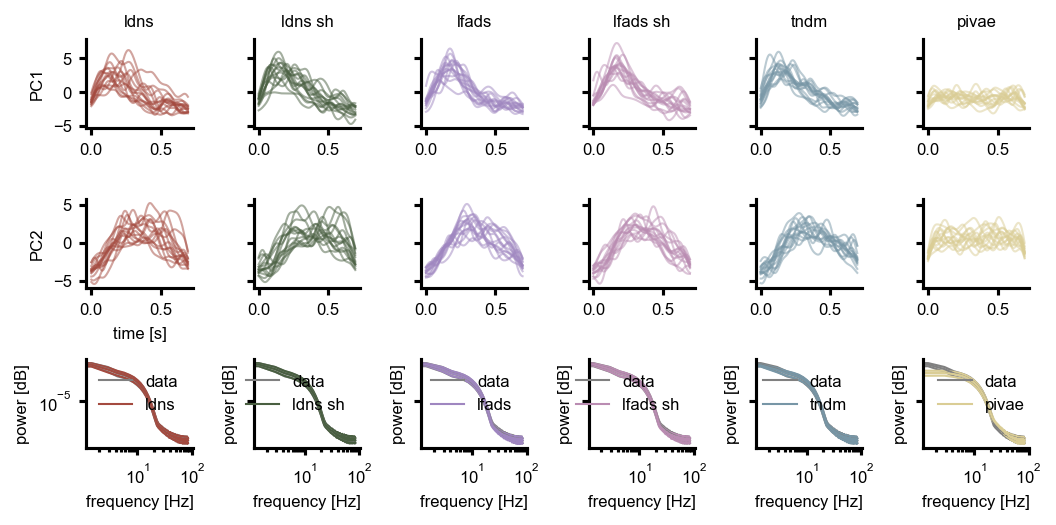

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from scipy import signal

fps = 1000 / 5
set_seed(42)
mse_median = {}
mse_95 = {}
mse_5 = {}

mse_median_5fold = {}
mse_95_5fold = {}
mse_5_5fold = {}
mse_agregate_5fold = {}
percentile_range = np.linspace(0.05, 0.95, 19)

time_speps = 140
time_array = np.arange(0, time_speps, 1) / fps

dt = 0.005  # 5 ms
win_len = 8
win_std = 0.03  # 30 ms
smo_window = signal.windows.gaussian(int(win_len * win_std / dt), int(win_std / dt))
smo_window /= smo_window.sum()
mse_median = {}

# Fit PCA on 'gt_spikes'
gt_data = spikes_to_analyse_with_LFADS["gt_spikes"]
gt_data = gt_data.transpose(0, 2, 1)


gt_data = np.apply_along_axis(lambda m: np.convolve(m, smo_window, mode="same"), axis=2, arr=gt_data)

n_samples, n_neurons, time_steps = gt_data.shape
gt_data_reshaped = gt_data.transpose(0, 2, 1).reshape(-1, n_neurons)

print(gt_data_reshaped.shape)
# Standardize the
scaler = StandardScaler()
gt_data_standardized = scaler.fit_transform(gt_data_reshaped)


pca = PCA(n_components=5)
pca.fit(gt_data_standardized)

train_transformed = pca.transform(gt_data_standardized)
pca_train_transformed = train_transformed.reshape(n_samples, time_steps, 5).transpose(0, 2, 1)

color_dict = {
    "pivae": "#DACD95",
    "tndm": "#7796A6",
    "lfads": "#9f86c0",
    "ldns": "#A44A3F",
    "lfadshist": "#BA8CB2",
    "hist": "#495F41",
    "train": "grey",
}

color_dict_comp_latent = {
    "pivae": "#DACD95",
    "tndm": "#7796A6",
    "lfads_spikes": "#9f86c0",
    "lfadshist_spikes": "#BA8CB2",
    "ldns_spikes": "#A44A3F",
    "hist_spikes": "#495F41",
    "gt_spikes": "grey",
}

label_dict = {
    "lfads_spikes": "lfads",
    "lfadshist_spikes": "lfads sh",
    "ldns_spikes": "ldns",
    "hist_spikes": "ldns sh",
    "gt_spikes": "data",
    "tndm": "tndm",
    "pivae": "pivae",
}

methods_to_plot = ["ldns_spikes", "hist_spikes", "lfads_spikes", "lfadshist_spikes", "tndm", "pivae"]

fig_composite, ax_composite = plt.subplots(
    3, len(methods_to_plot), figsize=cm2inch(len(methods_to_plot) * 3, 9), sharey="row"
)


# process each model using the fitted PCA
for mm, model in enumerate(methods_to_plot):
    data = spikes_to_analyse_with_LFADS[model]  # [1000:]
    data = data.transpose(0, 2, 1)

    data = np.apply_along_axis(lambda m: np.convolve(m, smo_window, mode="same"), axis=2, arr=data)

    # reshape the data to apply PCA on latents dimension
    n_samples, n_neurons, time_steps = data.shape
    data_reshaped = data.transpose(0, 2, 1).reshape(-1, n_neurons)

    data_standardized = scaler.transform(data_reshaped)
    # transform data using the PCA fitted on 'gt_spikes'
    pca_result = pca.transform(data_standardized)

    # reshape PCA result back to original sample and time steps
    pca_result_reshaped = pca_result.reshape(n_samples, time_steps, 5).transpose(0, 2, 1)

    # first five principal components over time
    for idx in range(15):  # range(n_samples):
        ax_composite[0, mm].plot(
            time_array, pca_result_reshaped[idx, 0, :], alpha=0.5, color=color_dict_comp_latent[model], label=model
        )
        ax_composite[1, mm].plot(
            time_array, pca_result_reshaped[idx, 1, :], alpha=0.5, color=color_dict_comp_latent[model], label=model
        )

    ax_composite[0, mm].set_title(label_dict[model])

    vals = plot_n_channel_sd_ax(
        pca_train_transformed.transpose(0, 2, 1),
        pca_result_reshaped.transpose(0, 2, 1),
        channels=[0],
        colors=["grey", color_dict_comp_latent[model]],
        labels=["data", label_dict[model]],
        fps=fps,
        axs=ax_composite[2, mm],
        fig=fig_composite,
        lw=1,
        idx=1,
    )

    mse_median[model] = mean_squared_error(np.median(vals["Pxy_one"], axis=0), np.median(vals["Pxy_two"], axis=0))

    # compute the 95 and 5 quantiles
    mse_95[model] = mean_squared_error(
        np.quantile(vals["Pxy_one"], 0.95, axis=0), np.quantile(vals["Pxy_two"], 0.95, axis=0)
    )
    mse_5[model] = mean_squared_error(
        np.quantile(vals["Pxy_one"], 0.05, axis=0), np.quantile(vals["Pxy_two"], 0.05, axis=0)
    )

    # now 5 randomly sampled subsets of the data with 500 samples each
    mse_median_5fold[model] = []
    mse_95_5fold[model] = []
    mse_5_5fold[model] = []
    mse_agregate_5fold[model] = []
    set_seed(0)
    for i in range(5):
        indices = np.random.choice(len(gt_data), int(len(gt_data) / 2), replace=False)

        mse_median_5fold[model].append(
            mean_squared_error(np.median(vals["Pxy_one"], axis=0), np.median(vals["Pxy_two"][indices], axis=0))
        )
        mse_95_5fold[model].append(
            mean_squared_error(
                np.quantile(vals["Pxy_one"], 0.95, axis=0), np.quantile(vals["Pxy_two"][indices], 0.95, axis=0)
            )
        )
        mse_5_5fold[model].append(
            mean_squared_error(
                np.quantile(vals["Pxy_one"], 0.05, axis=0), np.quantile(vals["Pxy_two"][indices], 0.05, axis=0)
            )
        )
        mse_agregate_5fold[model].append(
            mean_squared_error(
                np.quantile(vals["Pxy_one"], percentile_range, axis=0),
                np.quantile(vals["Pxy_two"][indices], percentile_range, axis=0),
            )
        )
ax_composite[0, 0].set_ylabel("PC1")
ax_composite[1, 0].set_ylabel("PC2")
ax_composite[1, 0].set_xlabel("time [s]")

fig_composite.tight_layout()
fig_composite.savefig(save_path + f"Plot_first_two_PCS_model_comparison_with_PSD.png")
fig_composite.savefig(save_path + f"Plot_first_two_PCS_model_comparison_with_PSD.pdf")